<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
    TimeSeriesSplit,
    train_test_split
)
from statsmodels.tsa.seasonal import seasonal_decompose
RANDOM_STATE = 42

В одном месте импортируем все необходимые библиотеки и модули.

In [ ]:
data = pd.read_csv('/datasets/taxi.csv')
display(data.head())
data.info()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [ ]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Знакомимся с данными. Столбец с датой делаем индексом. Ставим parse_dates для того, чтобы преобразовать столбец с датой из типа object в тип datetimes. Далее для удобства анализа сортируем его.

In [ ]:
data.sort_index(inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Как мы видим, у исходных данных интервал 10 минут, изменим его на 1 час.

In [ ]:
data_1h = data.resample('1H').sum()
data_1h.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


ВЫВОД: Данные без пропусков, изменили интервал данных с 10 минут на 1 час, узнали временной промежуток всего датасета - 2018-03-01 00:00:00 to 2018-08-31 23:50:00.

## Анализ

Создадим функции для вывода графиков для исследования данных.

In [ ]:
figsize = (20, 5)

def set_plot_properties(title, xlabel, ylabel):
    plt.title(title, y=1.2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

def create_plot(data, data_2, time_range, title, title_2):
    sns.set_style('darkgrid')
    data[time_range].plot(ax=plt.gca(), figsize=figsize)

    if data_2 is not None:
        data_2[time_range].plot(ax=plt.gca(), figsize=figsize)
        plt.legend(['Количество заказов', title_2])
    else:
        plt.legend(['Количество заказов'])

    set_plot_properties(title, 'Дата', 'Количество')

def make_plot(data, title, data_2=None, title_2=None):
    print('График за весь срок')
    create_plot(data, data_2, slice(None, None), title, title_2)

    print('График за месяц')
    create_plot(data, data_2, slice('2018-08', '2018-08'), title, title_2)

    print('График за три дня')
    create_plot(data, data_2, slice('2018-08-29', '2018-08-31'), title, title_2)

График за весь срок


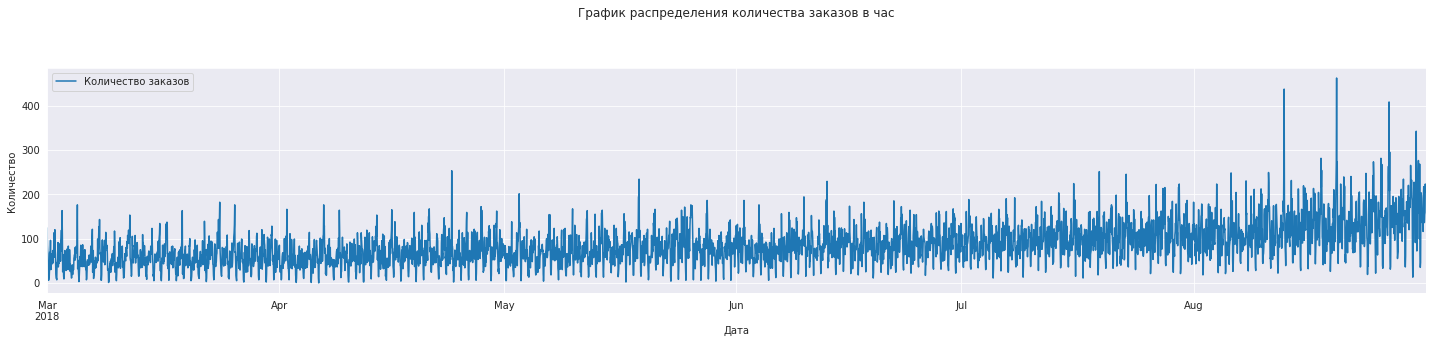

График за месяц


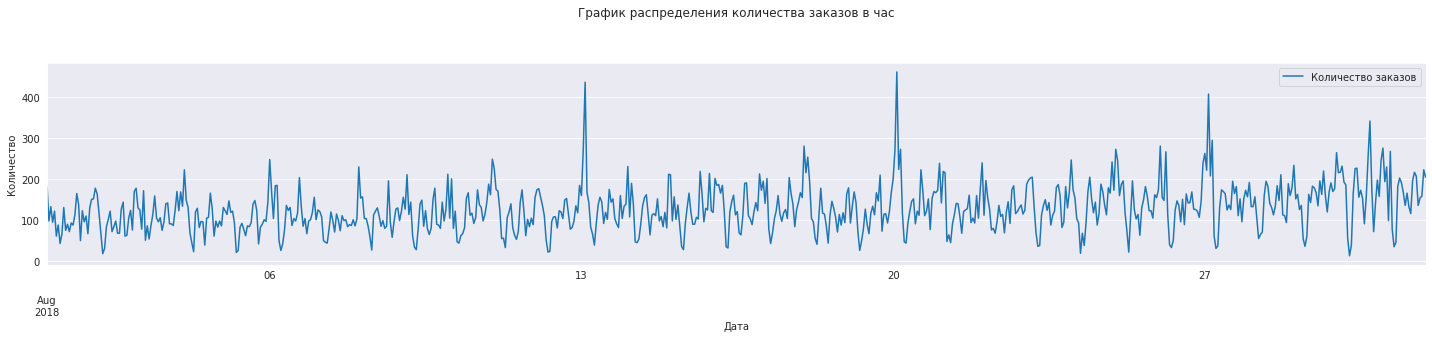

График за три дня


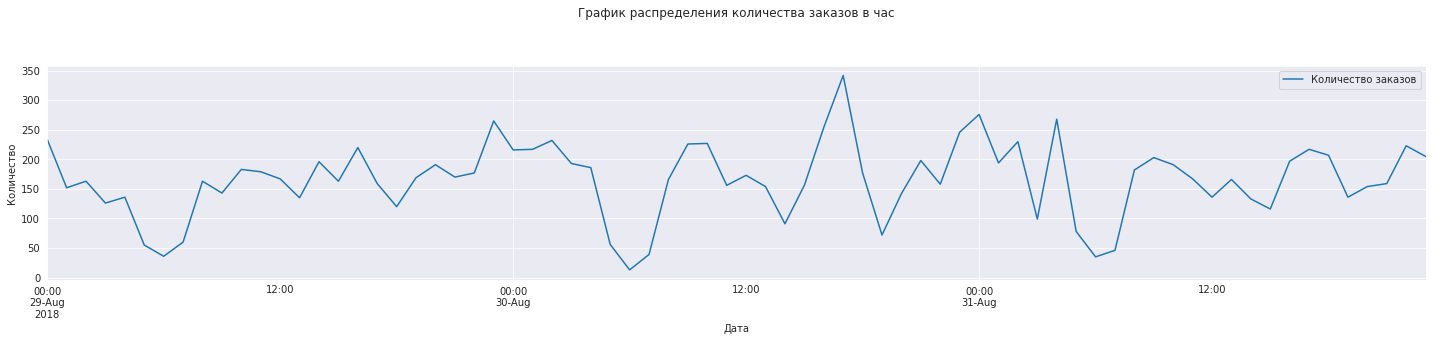

In [ ]:
make_plot(data_1h, 'График распределения количества заказов в час', None, None)

График за весь срок


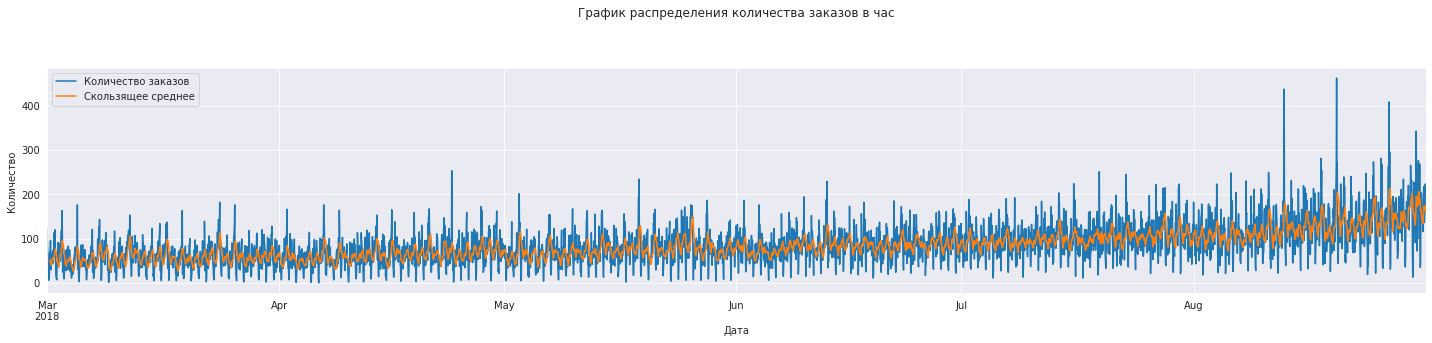

График за месяц


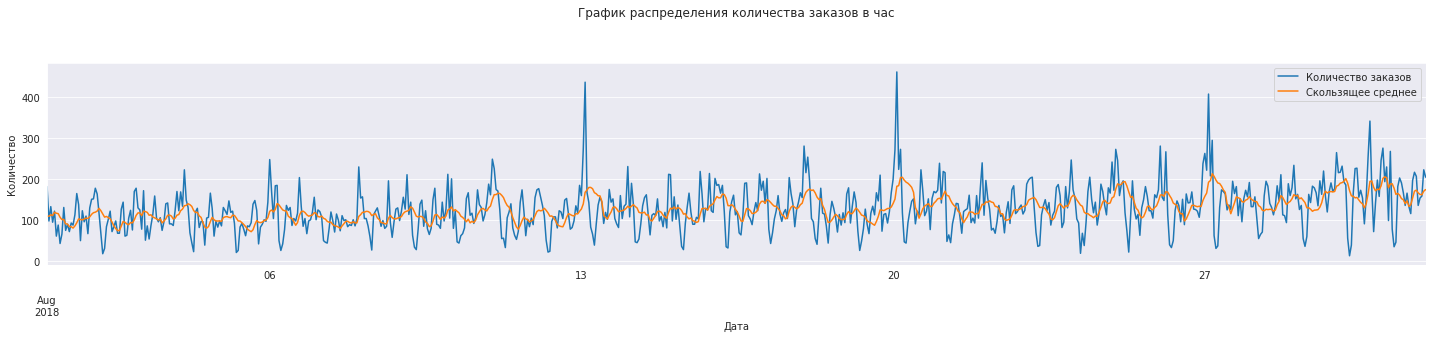

График за три дня


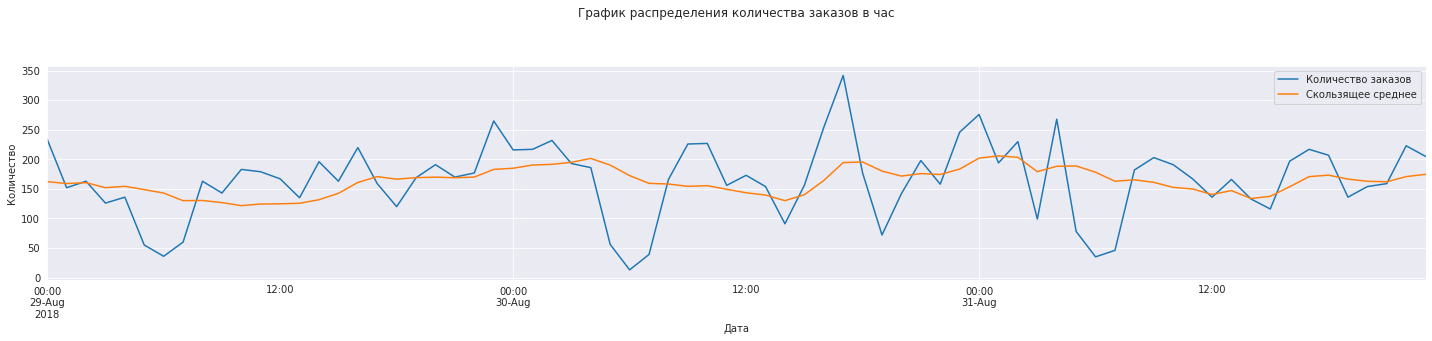

In [ ]:
make_plot(data_1h, 'График распределения количества заказов в час', data_1h.rolling(10).mean(), 'Скользящее среднее')

На графике за весь период видно, что среднее количество заказов растет.

Исследуем тренд, сезонность и остаток декомпозиции заказов такси.

ТРЕНД

In [ ]:
decomposed_data = seasonal_decompose(data_1h)

График за весь срок


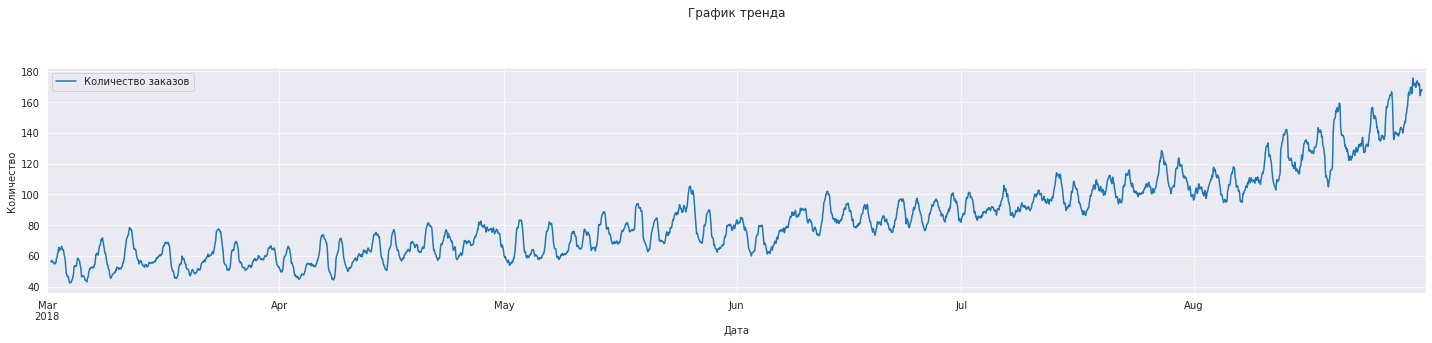

График за месяц


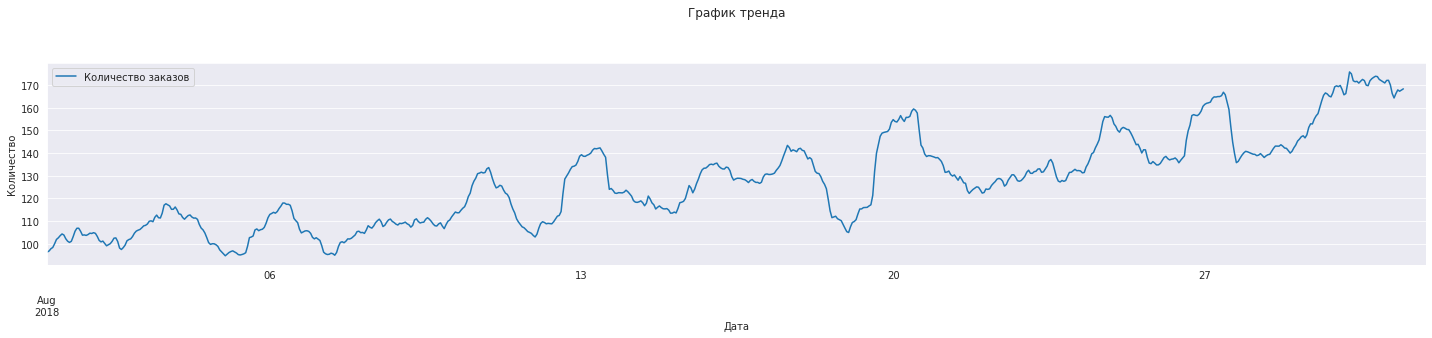

График за три дня


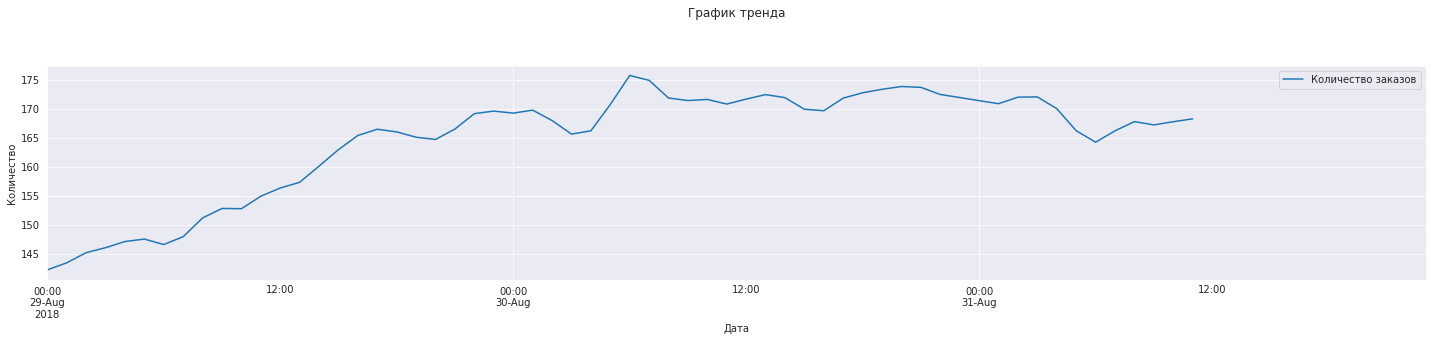

In [ ]:
make_plot(decomposed_data.trend, 'График тренда', None, None)

Явно прослеживается рост количества заказов с марта 2018 года.

In [ ]:
print('Стандартное отклонение: ',decomposed_data.trend.std())

Стандартное отклонение:  26.31141879619486


СЕЗОННОСТЬ

График за весь срок


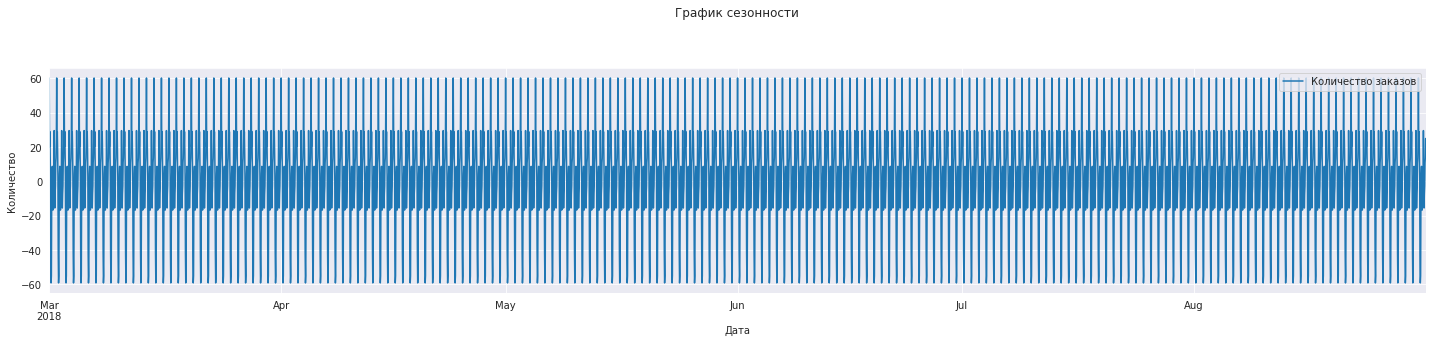

График за месяц


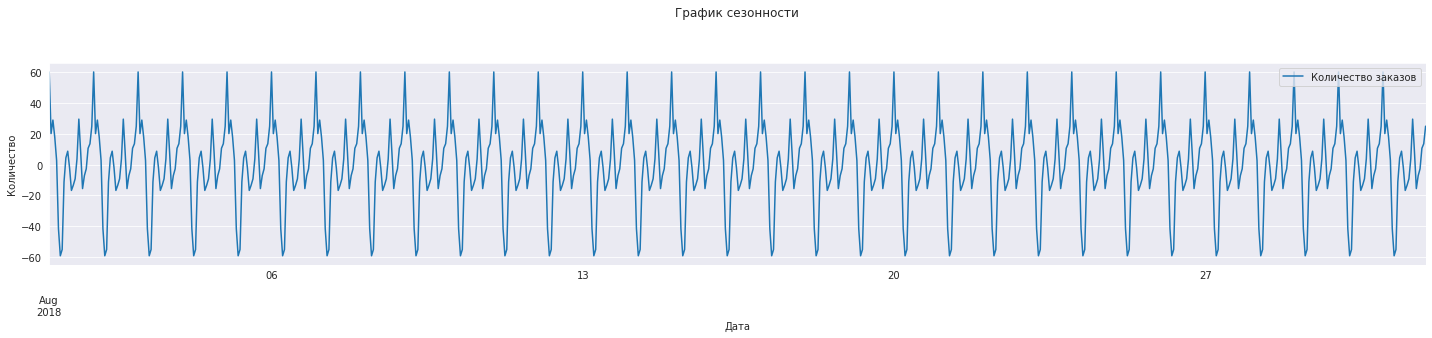

График за три дня


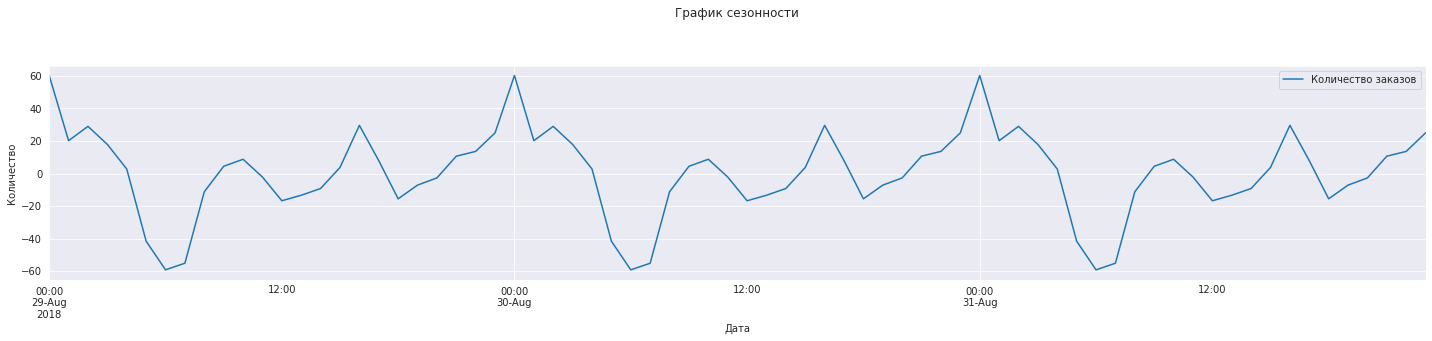

In [ ]:
make_plot(decomposed_data.seasonal, 'График сезонности', None, None )

1. На графике сезонности видно, что временной ряд не имеет тренда(среднее значение и стандратное отклонение не меняются).
2. На графике за 3 дня видно, что количество заказов сильно падает и достигает минимума в районе 6-7 часов утра. Сильный рост заказов приходится примерно в 9-10 утра, а достигает максимума в полночь. Значительный спад также наблюдается в районе 18 часов.

ОСТАТКИ ДЕКОМПОЗИЦИИ

График за весь срок


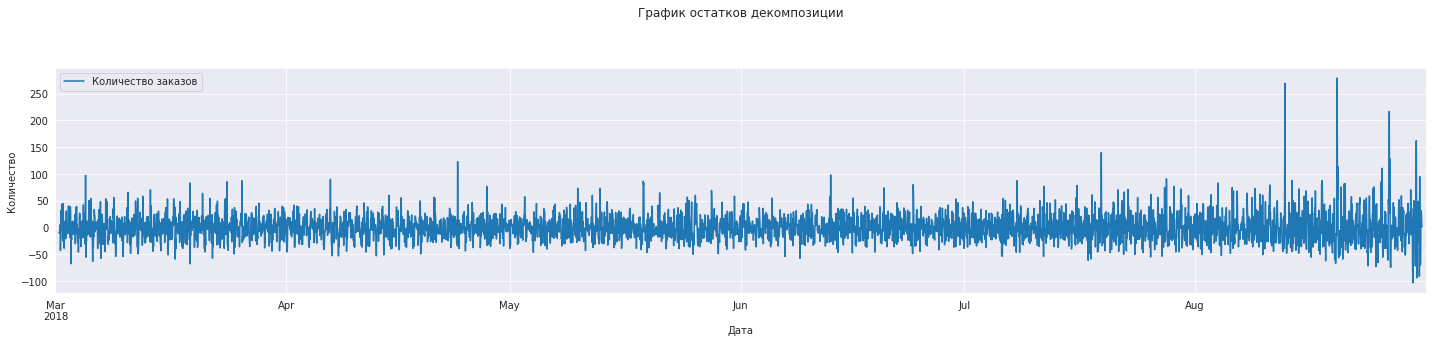

График за месяц


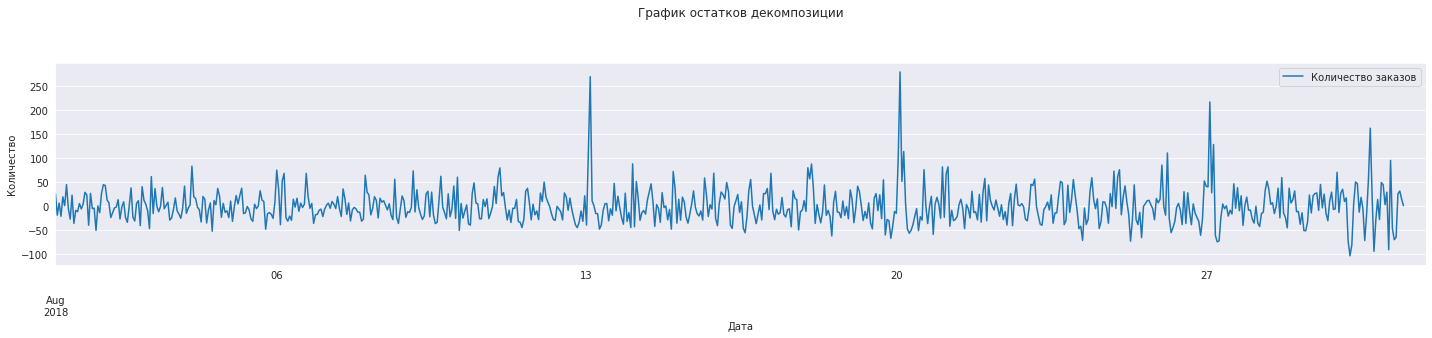

График за три дня


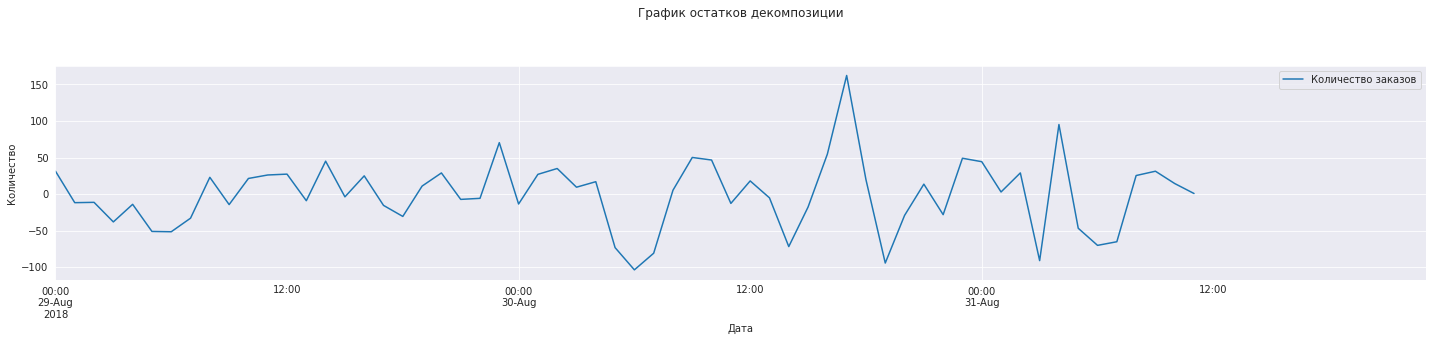

In [ ]:
make_plot(decomposed_data.resid, 'График остатков декомпозиции', None, None)

<AxesSubplot:xlabel='datetime'>

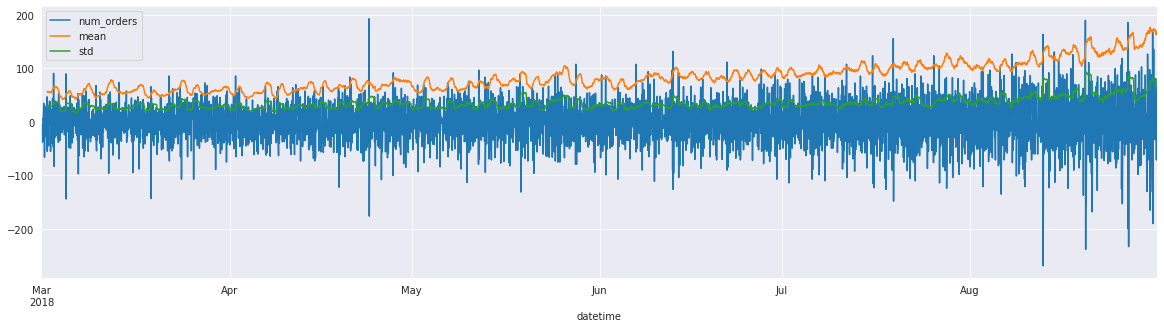

In [ ]:
shift_df = data_1h.diff()
shift_df['mean'] = data_1h['num_orders'].rolling(24).mean()
shift_df['std'] = data_1h['num_orders'].rolling(24).std()
shift_df.plot(figsize=figsize)

ОБЩИЙ ВЫВОД:

1. Данные проанализированы, изменен интервал данных с 10 минут на 1 час, узнали временной промежуток даатсета - 6 месяцев из 2018 года с марта по август.

2. Тренд идет на возрастание - это видно и на графике тренда, и на графике ресемплированных по 1 часу данных. На графике остатков декомпозиции также видны всплески.

3. Прослеживается суточная сезонность - больше всего заказов 09:00 и 00:00, меньше всего в районе 06:00 и 18.00(час-пик во время рабочего времени итд).

4. Также дни недели отличаются по количеству заказов, поэтому будем их учитывать(возможно, выходные влияют).


## Обучение

Создадим функцию для создания новых признаков для обучения модели.

Выбранные признаки:

1. День недели - от 1 до 7

2. Конкретное время в часах - учитываем влияние суток

3. Временные задержки (lags)

4. Скользящее среднее (Rolling mean)

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data = data.copy()
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [ ]:
data_with_features = make_features(data_1h, 4, 24)
data_with_features.head(10)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN
2018-03-01 05:00:00,6,3,5,43.0,66.0,71.0,85.0,NaN
2018-03-01 06:00:00,12,3,6,6.0,43.0,66.0,71.0,NaN
2018-03-01 07:00:00,15,3,7,12.0,6.0,43.0,66.0,NaN
2018-03-01 08:00:00,34,3,8,15.0,12.0,6.0,43.0,NaN


In [ ]:
data_with_features.dropna(inplace=True)
data_with_features

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,
2018-03-02 00:00:00,90,4,0,58.0,113.0,66.0,61.0,56.833333
2018-03-02 01:00:00,120,4,1,90.0,58.0,113.0,66.0,55.416667
2018-03-02 02:00:00,75,4,2,120.0,90.0,58.0,113.0,56.875000
2018-03-02 03:00:00,64,4,3,75.0,120.0,90.0,58.0,57.041667
2018-03-02 04:00:00,20,4,4,64.0,75.0,120.0,90.0,56.958333
...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,197.0,116.0,164.875000
2018-08-31 20:00:00,154,4,20,136.0,207.0,217.0,197.0,167.541667
2018-08-31 21:00:00,159,4,21,154.0,136.0,207.0,217.0,168.041667


Избавились от пропусков в новом датасете.

Разделим датасет на features и target. Их также разобьем в соотношении 90:10. Обязательно используем параметр shuffle = False, так как в задачах временного ряда нельзя перемешивать выборки. Проверим размер.

In [ ]:
features = data_with_features.drop('num_orders', axis=1)
target = data_with_features['num_orders']

features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            shuffle=False,
                                                                            test_size=0.1)
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3952, 7)
(440, 7)
(3952,)
(440,)


Будем обучать 3 модели:

1.   Линейная регрессия.

2.  Случайный лес (RandomForestRegressor).

3. CatBoost.

Качество моделей измерим кросс-валидацией с метрикой RMSE. Деление на фолды поможет избежать переобучения.

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
%%time

scores = cross_val_score(LinearRegression(), features_train, target_train, scoring='neg_root_mean_squared_error', cv=tscv)

lr_RMSE = scores.mean() * -1
print(f"RMSE: {lr_RMSE:.1f}")

RMSE: 31.7
CPU times: user 58.6 ms, sys: 7.96 ms, total: 66.6 ms
Wall time: 45.3 ms


In [ ]:
%%time
model_rf = RandomForestRegressor(random_state=RANDOM_STATE)

param_grid_rf = {
    'n_estimators': range(1, 505, 100),
    'max_depth': range(17, 19)
}

gs_rf = GridSearchCV(
    model_rf,
    param_grid=param_grid_rf,
    n_jobs=-1,
    cv=tscv,
    scoring='neg_root_mean_squared_error')

gs_rf.fit(features_train, target_train)
print(f'best_params: {gs_rf.best_params_}')

best_params: {'max_depth': 17, 'n_estimators': 501}
CPU times: user 2min 2s, sys: 651 ms, total: 2min 3s
Wall time: 2min 3s


In [ ]:
results_rf = gs_rf.cv_results_
best_index_rf = gs_rf.best_index_
rf_RMSE = results_rf['mean_test_score'][best_index_rf] * -1
print(f"Best RMSE: {rf_RMSE}")

Best RMSE: 25.381628480582158


In [ ]:
%%time
model_catboost = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)

param_grid_catboost = {
    'iterations': range(100, 501, 100),
    'learning_rate': [0.05, 0.1],
    'depth': range(2, 9, 3)
}

gs_catboost = GridSearchCV(
        model_catboost,
        param_grid=param_grid_catboost,
        cv=tscv,
        scoring='neg_root_mean_squared_error'
)

gs_catboost.fit(features_train, target_train)
print(f'best_params: {gs_catboost.best_params_}')

best_params: {'depth': 5, 'iterations': 500, 'learning_rate': 0.05}
CPU times: user 1min 12s, sys: 4.01 s, total: 1min 16s
Wall time: 4min


In [ ]:
results_catboost = gs_catboost.cv_results_
best_index_catboost = gs_catboost.best_index_

catboost_RMSE = results_catboost['mean_test_score'][best_index_catboost] * -1

print(f"Best RMSE: {catboost_RMSE}")

Best RMSE: 25.399100150774956


In [ ]:
result = pd.DataFrame(
     [lr_RMSE, rf_RMSE, catboost_RMSE] ,
    index=['LinearRegression','RandomForestRegressor', 'CatBoost'],
    columns=['RMSE']
)
result

,RMSE
LinearRegression,31.671323
RandomForestRegressor,25.381628
CatBoost,25.399100


Лидирует RandomForestRegressor с гиперпараметрами max_depth = 17 и n_estimators = 501. Проверим его на тестовой выборке.

## Тестирование

In [ ]:
def make_two_plots(target_data, predicted_data):
    plt.figure(figsize=figsize)
    plt.plot(target_data.index,
             target_data,
             target_data.index,
             predicted_data)
    plt.title('График реальных значений целевого признака и предсказаний')
    plt.xlabel('Дата/время')
    plt.ylabel('Число заказов')
    plt.legend(['Реальные значения', 'Предсказанные значения'])
    plt.show()

In [ ]:
%%time

target_predict_rf = gs_rf.predict(features_test)
final_RMSE_rf = mean_squared_error(target_test, target_predict_rf) ** 0.5

print(final_RMSE_rf)


45.94443635028075
CPU times: user 73 ms, sys: 2 µs, total: 73 ms
Wall time: 71.3 ms


Метрика RMSE удоволетворяет условию - она меньше 48, поэтому задачу можно считать выполненной.


ОБЩИЙ ВЫВОД:

В ходе проекта мной было выполнено несколько задач.

1. Данные временного ряда изучены и преобразованы. Исследованы тренд, сезонность и остатки декомпозиции.

2. Выбраны признаки для обучения модели - среди них день недели, время суток, временные задержки и скользящее среднее.

3. Обучены 3 модели - Линейная регрессия, Случайный лес и CatBoost. Лучшим оказался RandomForestRegressor с результатом RMSE = 45.9 на тестовой выборке.